<a href="https://colab.research.google.com/github/codewithhari98/Machine_Learning/blob/main/Neural_network_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
#https://dillhoffaj.utasites.cloud/posts/neural_networks/
#https://github.com/ajdillhoff/CSE6363/blob/main/neural_networks/mlp.ipynb
#https://github.com/ajdillhoff/CSE6363/blob/main/neural_networks/mlp.ipynb
#https://www.youtube.com/watch?v=RSl87lqOXDE&ab_channel=CoreySchafer
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce654
#https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
#http://neuralnetworksanddeeplearning.com/chap1.html
#https://www.educative.io/answers/one-hot-encoding-in-python
#https://e2eml.school/softmax.html
import numpy as np
import pickle
import pandas as pd
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Parent Class Layer is Initialized
class Layer:
  def __init__(self,inputsize,outputsize,weights_arr=[0],bias_arr=[0]):
    self.input=inputsize
    self.output=outputsize
    if(len(weights_arr)!= len(bias_arr)):
          self.weights=weights_arr
          self.bias=bias_arr
    else:
          self.weights = np.random.rand(inputsize, outputsize) - 0.5
          self.bias = np.random.rand(1, outputsize) - 0.5
    self.z=0
  def forward(self, input):
    raise NotImplementedError
  def backward(self, output_error, learning_rate):
     raise NotImplementedError
    

In [186]:
#Linear Layer is initialized and weights and biases are updated here using forward and backward propagation
class linearlayer(Layer):
  def forward(self,input):
    self.input_data=input
    f=np.dot(self.input_data, self.weights) + self.bias
    return f
  def backward(self,output_error,learning_rate):
    #diff of function f wrt weights gives input data 
    dfw=self.input_data
    dfx=self.weights
    #calculating sensitivity of cost wrt previous activation layer
    input_error = np.dot(output_error, dfx.T)
    #calculating sensitivity of cost wrt change in weights
    weights_error = np.dot(dfw.T, output_error)
    
    self.weights=self.weights-learning_rate*weights_error
    self.bias=self.bias-learning_rate*output_error

    #this returns the sensitivity of the cost func wrt previous activation func
    #which will be useful to calc the change in weights needed at inp
    return input_error

In [187]:
#Sigmoid activation function class is initialized 
class sigmoid(Layer):
  def __init__(self):
    pass
  #forward propagation sigmoid(z) formula is found using formula as 1/(1+e-x)
  def forward(self,input):
    self.input_data=input
    #return 1. / (1. + np.exp(-self.z))
    return 1. / (1. + np.exp(-self.input_data))
  #backward propagation sigmoid_prime(z) is found using formula
  def backward(self, output_error, learning_rate):
    sig_prime= (1. / (1. + np.exp(-self.input_data)))*(1- (1. / (1. + np.exp(-self.input_data))))*output_error
    return sig_prime

In [188]:
#Tanh activation function class is initialized 
class tanh(Layer):
  def __init__(self):
    pass
  #forward propagation tanh(z) formula is found using formula as (e^x-e^-x)/(e^x+e^-x)
  def forward(self,input):
    self.input_data=input
    tanh_val=(np.exp(self.input_data) - np.exp(-self.input_data)) / (np.exp(self.input_data) + np.exp(-self.input_data))
    return tanh_val

  #backward propagation tanh_prime(z) is found using formula as (1-tanh^2)
  def backward(self, output_error,learning_rate):
    tanh_val=(np.exp(self.input_data) - np.exp(-self.input_data)) / (np.exp(self.input_data) + np.exp(-self.input_data))
    tanh_prime= (1-(tanh_val)**2)*output_error 
    return tanh_prime

In [189]:
#softmax activation function class is initialized 
class softmax(Layer):
  def forward(self,input):
    self.input_data=input
    self.z=(np.dot(self.input_data, self.weights) + self.bias)
    num = np.exp(self.z- np.max(self.z))
    return num / np.sum(num, axis=0, keepdims=True)

  def backward(self, probs, bp_err):
    dim = probs.shape[1]
    output = np.empty(probs.shape)
    for j in range(dim):
        d_prob_over_xj = - (probs * probs[:,[j]])  # i.e. prob_k * prob_j, no matter k==j or not
        d_prob_over_xj[:,j] += probs[:,j]   # i.e. when k==j, +prob_j
        output[:,j] = np.sum(bp_err * d_prob_over_xj, axis=1)
    return output

In [190]:
#Crossentropy class initiallized
class crossentropy(Layer):
  def forward(pred, target):
    return -target * np.log(pred)
  def backward(pred, target):
    return target - pred

In [191]:
#to calculate the loss function and its derivative
#class mean square error:
def mse(y_true, y_pred):
  return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
  return 2*(y_pred-y_true)/y_true.size;

In [192]:
class sequential_class(Layer):
  #we initalise loss and loss_grad as none to change is varianbly between mse and crossentropy loss
  def __init__(self,loss=None,loss_grad=None):
    self.layers = []
    self.loss=loss
    self.loss_grad=loss_grad
  #new layers are added here
  def add_layer(self,newlayer):
    self.layers.append(newlayer)
    return(self.layers)
  #this is to display weights when user re
  def display_weights(self):
    for layer in self.layers:
      print(layer.weights)
  def predict(self,input):
    samplesize=len(input)
    predictions=[]
    for i in range(samplesize):
      output=input[i]
      #print("output1= ",samplesize)
      for layer in self.layers:
        output = layer.forward(output)
        #print("output= "+str(layer),output)
      predictions.append(output)
    return predictions
  def fit(self, x_train, y_train, epochs, learning_rate,modelname=""):
    count=0
    self.modelname=modelname
    samplesize=len(x_train)
    list_of_epochs = []
    list_of_errors = []
    for i in range(epochs):
      errorval=0
      for j in range(samplesize):
      # forward propagation
        output = x_train[j]
        #print(output)
        for layer in self.layers:
          #print(layer)
          output = layer.forward(output)
        errorval += self.loss(y_train[j], output)
          # backward propagation
        error = self.loss_grad(y_train[j], output)
        for layer in reversed(self.layers):
          error = layer.backward(error, learning_rate)

      # calculate average error on all samples
      errorval /= samplesize
      list_of_errors.append(errorval)
      if((errorval==list_of_errors[-1]) and (count==5)):
        break
        count+=1
      #print(len(list_of_errors))
      list_of_epochs.append(i)
      print('epoch %d/%d   error=%f' % (i+1, epochs, errorval))
      if(count==5):
        break
    fig = plt.figure(figsize=[6,10])
    ax = fig.add_subplot(1,1, 1)
    ax.plot(list_of_epochs,list_of_errors, color='b', linestyle="-")
    ax.set_title(modelname)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

  def testaccuracy(self, y_pred, y):
    samples = len(y_pred)
    accuracy = 0
    for i in range(samples):
      abs_out = np.array([abs(np.round(x)) for x in y_pred[i]])[0]
      if np.array_equal(abs_out,np.array(y[i])):
        accuracy += 1
    return accuracy/samples     


In [193]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [194]:
def XOR_Test():
  x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
  y_train = np.array([[[0]], [[1]], [[1]], [[0]]])
  XOR_Model1=sequential_class(mse,mse_prime)
  XOR_Model1.add_layer(linearlayer(2,2))
  XOR_Model1.add_layer(sigmoid())
  XOR_Model1.add_layer(linearlayer(2,1))
  XOR_Model1.add_layer(sigmoid())
  XOR_Model1.fit(x_train, y_train, epochs=5000, learning_rate=0.01,modelname='XOR prediction using Sigmoid Training: ')
  out_sigmoid = XOR_Model1.predict(x_train)
  with open('XOR_solved_sigmoid.w', 'wb') as files:
     pickle.dump(XOR_Model1, files)
  print("XOR prediction using Sigmoid Training: ",out_sigmoid)
  print("\n----------------------------------------------------------\n")

  XOR_Model2=sequential_class(mse,mse_prime)
  XOR_Model2.add_layer(linearlayer(2,2))
  XOR_Model2.add_layer(tanh())
  XOR_Model2.add_layer(linearlayer(2,1))
  XOR_Model2.add_layer(tanh())
  XOR_Model2.fit(x_train, y_train, epochs=5000, learning_rate=0.01,modelname='XOR prediction using Tanh Training: ')
  out_tanh = XOR_Model2.predict(x_train)
  with open('XOR_solved_tanh.w', 'wb') as files:
     pickle.dump(XOR_Model2, files)
  print("XOR prediction using Tanh Training: ",out_tanh)
  print("\n----------------------------------------------------------\n")

In [195]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

In [196]:
def mnist_train_test():

  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  print("xtrain shape",len(x_train))
  print("xtest shape",len(x_test))
  # reshape and normalize input data
  x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
  x_train = x_train.astype('float32')
  x_train /= 255
  y_train = np_utils.to_categorical(y_train)
  # take some validation dataset aside from training dataset
  x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)
  x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
  x_test = x_test.astype('float32')
  x_test /= 255
  y_test = np_utils.to_categorical(y_test)
  
  print("\n\n Model 1")
  mnist_network_layer1 = sequential_class(mse,mse_prime)
  mnist_network_layer1.add_layer(linearlayer(28*28, 100))                
  mnist_network_layer1.add_layer(tanh())
  mnist_network_layer1.add_layer(linearlayer(100, 50))                   
  mnist_network_layer1.add_layer(tanh())
  mnist_network_layer1.add_layer(linearlayer(50, 10))                    
  mnist_network_layer1.add_layer(tanh())
  mnist_network_layer1.fit(x_train[:1000], y_train[:1000], epochs=100, learning_rate=0.1,modelname='Mnist Model 1: ')
  x_validation_pred = (mnist_network_layer1.predict(x_validation))
  print('Model 1 validation set Accuracy : ',mnist_network_layer1.testaccuracy(x_validation_pred,y_validation))
  x_testset_pred = (mnist_network_layer1.predict(x_test))
  print('Model 1 test set Accuracy : ',mnist_network_layer1.testaccuracy(x_testset_pred,y_test))
  samples = 5
  for test, true in zip(x_test[:samples], y_test[:samples]):
      pred = mnist_network_layer1.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print('mnist_network_layer1---pred: %s, true: %d' % (idx, idx_true))
  with open('mnist_network_layer1.w', 'wb') as files:
     pickle.dump(mnist_network_layer1, files)

  print("\n\n Model 2")
  mnist_network_layer2 = sequential_class(mse,mse_prime)
  mnist_network_layer2.add_layer(linearlayer(28*28, 50))                
  mnist_network_layer2.add_layer(sigmoid())
  mnist_network_layer2.add_layer(linearlayer(50, 50))                   
  mnist_network_layer2.add_layer(sigmoid())
  mnist_network_layer2.add_layer(linearlayer(50, 10))                    
  mnist_network_layer2.add_layer(tanh())
  mnist_network_layer2.fit(x_train[:1000], y_train[:1000], epochs=100, learning_rate=0.1,modelname='Mnist Model 2: ')
  x_validation_pred = (mnist_network_layer2.predict(x_validation))
  print('Model 2 validation set Accuracy : ',mnist_network_layer2.testaccuracy(x_validation_pred,y_validation))
  x_testset_pred = (mnist_network_layer2.predict(x_test))
  print('Model 2 test set Accuracy : ',mnist_network_layer2.testaccuracy(x_testset_pred,y_test))
  for test, true in zip(x_test[:samples], y_test[:samples]):
      pred = mnist_network_layer2.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print('mnist_network_layer2---pred: %s, true: %d' % (idx, idx_true))
  with open('mnist_network_layer2.w', 'wb') as files:
     pickle.dump(mnist_network_layer2, files)

  print("\n\n Model 3")
  mnist_network_layer3 = sequential_class(mse,mse_prime)
  mnist_network_layer3.add_layer(linearlayer(28*28, 200))                
  mnist_network_layer3.add_layer(tanh())
  mnist_network_layer3.add_layer(linearlayer(200, 100))                   
  mnist_network_layer3.add_layer(tanh())
  mnist_network_layer3.add_layer(linearlayer(100, 50))                    
  mnist_network_layer3.add_layer(tanh())
  mnist_network_layer3.add_layer(linearlayer(50, 25))                    
  mnist_network_layer3.add_layer(tanh())
  mnist_network_layer3.add_layer(linearlayer(25, 10))                    
  mnist_network_layer3.add_layer(tanh())
  mnist_network_layer3.fit(x_train[:1000], y_train[:1000], epochs=100, learning_rate=2,modelname='Mnist Model 3: ')
  x_validation_pred = (mnist_network_layer3.predict(x_validation))
  print('Model 3 validation set Accuracy : ',mnist_network_layer3.testaccuracy(x_validation_pred,y_validation))
  x_testset_pred = (mnist_network_layer3.predict(x_test))
  print('Model 3 test set Accuracy : ',mnist_network_layer3.testaccuracy(x_testset_pred,y_test))
  for test, true in zip(x_test[:samples], y_test[:samples]):
      pred = mnist_network_layer3.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print(' mnist_network_layer3--- pred: %s, true: %d' % (idx, idx_true))
  with open('mnist_network_layer3.w', 'wb') as files:
     pickle.dump(mnist_network_layer3, files)


In [197]:
def playing_with_hyperparameters():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  # reshape and normalize input data
  x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
  x_train = x_train.astype('float32')
  x_train /= 255
  y_train = np_utils.to_categorical(y_train)
  # take some validation dataset aside from training dataset
  x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)
  x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
  x_test = x_test.astype('float32')
  x_test /= 255
  y_test = np_utils.to_categorical(y_test)
  
  print("\n\n Hyperparameter Model 1")
  hyperparameter_network_layer1 = sequential_class(mse,mse_prime)
  hyperparameter_network_layer1.add_layer(linearlayer(28*28, 50, np.zeros([28*28,50]), np.zeros([1,50])))                
  hyperparameter_network_layer1.add_layer(tanh())
  hyperparameter_network_layer1.add_layer(linearlayer(50, 10))                    
  hyperparameter_network_layer1.add_layer(tanh())
  hyperparameter_network_layer1.fit(x_train[:1000], y_train[:1000], epochs=100, learning_rate=0.1,modelname='Playing with Hyperparameter Model 1: ')
  x_validation_pred = (hyperparameter_network_layer1.predict(x_validation))
  print('Hyperparameter Model 1 validation set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_validation_pred,y_validation))
  x_testset_pred = (hyperparameter_network_layer1.predict(x_test))
  print('Hyperparameter Model 1 test set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_testset_pred,y_test))
  samples = 5
  for test, true in zip(x_test[:samples], y_test[:samples]):
      pred = hyperparameter_network_layer1.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print('Hyperparameter Model 1---pred: %s, true: %d' % (idx, idx_true))
  with open('hyperparameter_network_layer1.w', 'wb') as files:
     pickle.dump(hyperparameter_network_layer1, files)

  print("\n\n Hyperparameter Model 2")
  high = 10
  low = -10   
  hyperparameter_network_layer2 = sequential_class(mse,mse_prime)
  hyperparameter_network_layer2.add_layer(linearlayer(28*28, 50, np.random.rand(28*28,50) * (high - low) + low, np.random.rand(1,50) * (high - low) + low ))                
  hyperparameter_network_layer2.add_layer(tanh())
  hyperparameter_network_layer2.add_layer(linearlayer(50, 10))                   
  hyperparameter_network_layer2.fit(x_train[:1000], y_train[:1000], epochs=100, learning_rate=0.1,modelname='Playing with Hyperparameter Model 2: ')
  x_validation_pred = (hyperparameter_network_layer1.predict(x_validation))
  print('Hyperparameter Model 2 validation set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_validation_pred,y_validation))
  x_testset_pred = (hyperparameter_network_layer1.predict(x_test))
  print('Hyperparameter Model 2 test set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_testset_pred,y_test))
  samples = 5
  for test, true in zip(x_test[:samples], y_test[:samples]):
      pred = hyperparameter_network_layer1.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print('Hyperparameter Model 2---pred: %s, true: %d' % (idx, idx_true))

  print("\n\n Hyperparameter Model 3")
  hyperparameter_network_layer3 = sequential_class(mse,mse_prime)
  hyperparameter_network_layer3.add_layer(linearlayer(28*28, 100))                
  hyperparameter_network_layer3.add_layer(tanh())                  
  hyperparameter_network_layer3.add_layer(linearlayer(100, 50))                  
  hyperparameter_network_layer3.add_layer(tanh())
  hyperparameter_network_layer3.add_layer(linearlayer(50, 10))                    
  hyperparameter_network_layer3.add_layer(tanh())

  hyperparameter_network_layer3.fit(x_train[:1000], y_train[:1000], epochs=100, learning_rate=1,modelname='Playing with Hyperparameter Model 3: ')
  x_validation_pred = (hyperparameter_network_layer1.predict(x_validation))
  print('Hyperparameter Model 3 validation set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_validation_pred,y_validation))
  x_testset_pred = (hyperparameter_network_layer1.predict(x_test))
  print('Hyperparameter Model 3 test set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_testset_pred,y_test))
  samples = 5
  for test, true in zip(x_test[:samples], y_test[:samples]):
      pred = hyperparameter_network_layer3.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print('Hyperparameter Model 3---pred: %s, true: %d' % (idx, idx_true))


  print("\n\n Hyperparameter Model 4")
  hyperparameter_network_layer4 = sequential_class(mse,mse_prime)
  hyperparameter_network_layer4.add_layer(linearlayer(28*28, 100))                
  hyperparameter_network_layer4.add_layer(tanh())
  hyperparameter_network_layer4.add_layer(linearlayer(100, 50))                   
  hyperparameter_network_layer4.add_layer(tanh())
  hyperparameter_network_layer4.add_layer(linearlayer(50, 10))                    
  hyperparameter_network_layer4.add_layer(tanh())
  hyperparameter_network_layer4.fit(x_train[:1000], y_train[:1000], epochs=100, learning_rate=0.001,modelname='Playing with Hyperparameter Model 4: ')
  x_validation_pred = (hyperparameter_network_layer1.predict(x_validation))
  print('Hyperparameter Model 4 validation set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_validation_pred,y_validation))
  x_testset_pred = (hyperparameter_network_layer1.predict(x_test))
  print('Hyperparameter Model 4 test set Accuracy : ',hyperparameter_network_layer1.testaccuracy(x_testset_pred,y_test))
  samples = 5
  for test, true in zip(x_test[:samples], y_test[:samples]):
      pred = hyperparameter_network_layer4.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print('Hyperparameter Model 4---pred: %s, true: %d' % (idx, idx_true))

In [198]:
def main():
  #print("...................................Doing Xor Testing...........................................\n\n")
  XOR_Test()
  #print("..................................Training and testing on mnist Dataset.........................\n\n" )
  mnist_train_test()
  print("..................................Playing with Hyperparameters.........................\n\n" )
  playing_with_hyperparameters()

Streaming output truncated to the last 5000 lines.
epoch 780/5000   error=0.192288
epoch 781/5000   error=0.192192
epoch 782/5000   error=0.192096
epoch 783/5000   error=0.192000
epoch 784/5000   error=0.191904
epoch 785/5000   error=0.191808
epoch 786/5000   error=0.191713
epoch 787/5000   error=0.191617
epoch 788/5000   error=0.191521
epoch 789/5000   error=0.191426
epoch 790/5000   error=0.191331
epoch 791/5000   error=0.191235
epoch 792/5000   error=0.191140
epoch 793/5000   error=0.191045
epoch 794/5000   error=0.190950
epoch 795/5000   error=0.190855
epoch 796/5000   error=0.190760
epoch 797/5000   error=0.190665
epoch 798/5000   error=0.190570
epoch 799/5000   error=0.190475
epoch 800/5000   error=0.190381
epoch 801/5000   error=0.190286
epoch 802/5000   error=0.190191
epoch 803/5000   error=0.190097
epoch 804/5000   error=0.190002
epoch 805/5000   error=0.189908
epoch 806/5000   error=0.189814
epoch 807/5000   error=0.189719
epoch 808/5000   error=0.189625
epoch 809/5000   erro

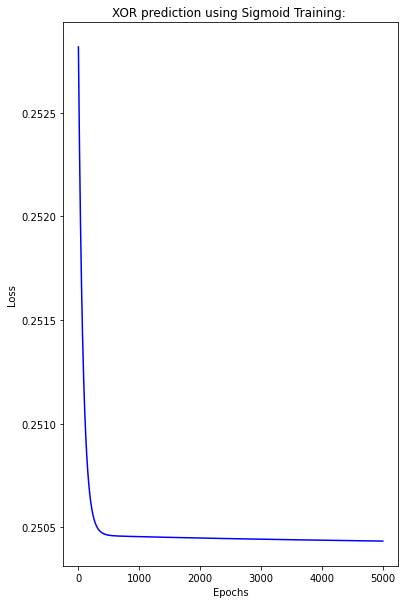

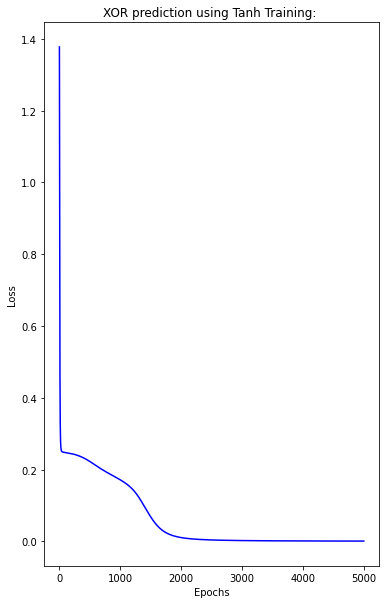

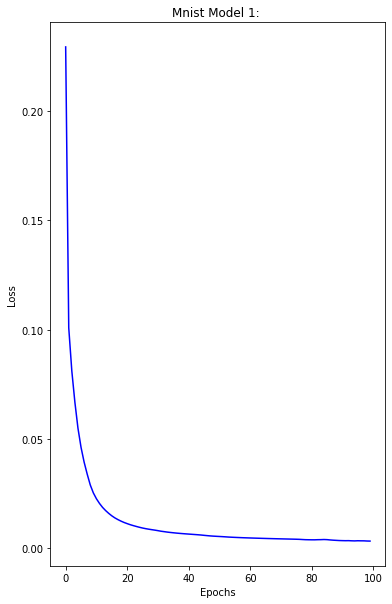

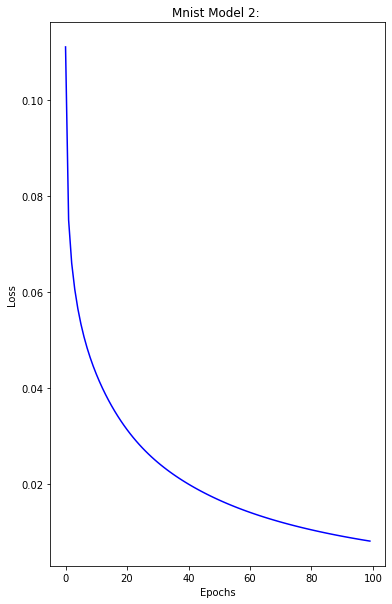

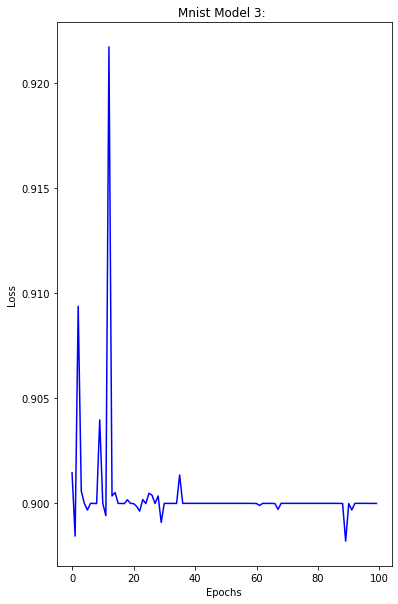

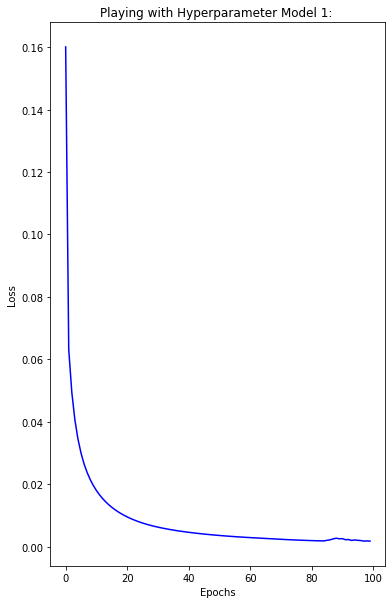

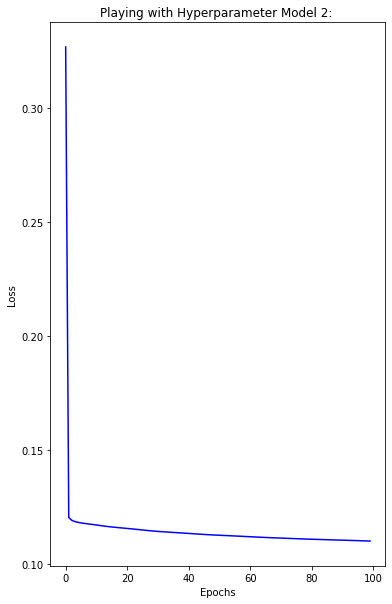

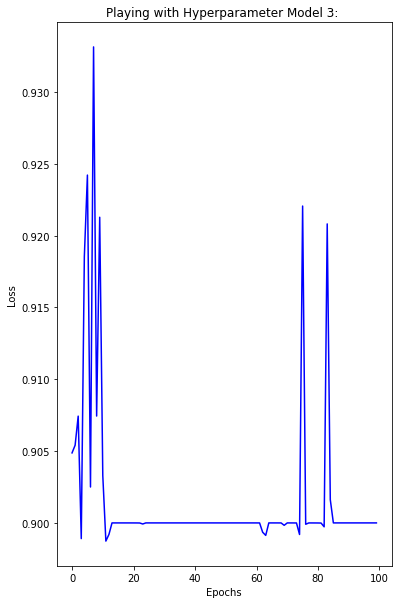

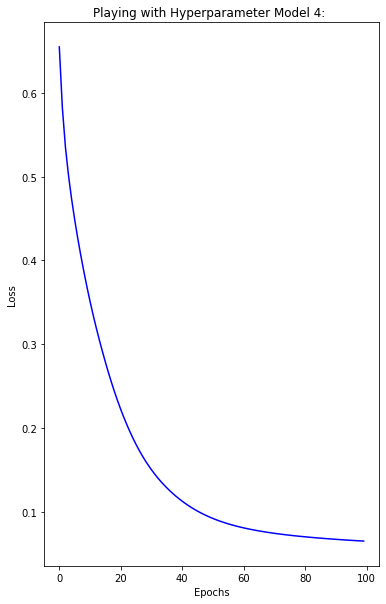

In [199]:
if __name__ == "__main__" :   
    main()